In [1]:
import numpy as np
import pandas as pd

import h2o

# Rossmann Store Sales

https://www.kaggle.com/c/rossmann-store-sales/data

Create alerting system for out of range store sales.

# Load data

In [2]:
# importing train data
train = pd.read_csv("./data/initial/rossmann-store-sales/train.csv", parse_dates=True, low_memory=False, index_col='Date')

# additional store data
store = pd.read_csv("./data/initial/rossmann-store-sales/store.csv", low_memory=False)

# Preprocessing

## Additional feature creation

In [3]:
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

## Drop closed stores and 0 sales

In [4]:
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

## Fillna

In [5]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)
store.fillna(0, inplace=True)

## Merge stores

In [6]:
# Merge stores

train = pd.merge(train.reset_index(), store, how='inner', on='Store', left_index=True).set_index('Date')

# Define target

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
mpl.rcParams.update({'font.size': 22})

import seaborn as sns

Text(0.5, 1.0, 'Average sales by StoreType')

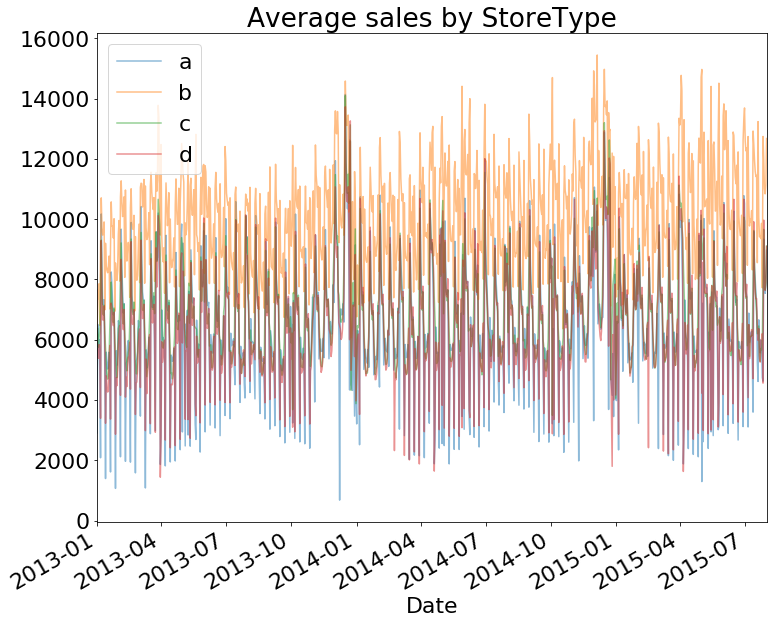

In [10]:
gb = train.reset_index().groupby(['StoreType', 'Date']).Sales.mean().reset_index().set_index('Date').groupby('StoreType').Sales

for key, value in gb:
    value.rolling(window=1).mean().plot(alpha=0.5)
plt.legend(['a', 'b', 'c', 'd'])
plt.title('Average sales by StoreType')

Text(0.5, 1.0, 'Rolling average sales by StoreType on 4 weeks')

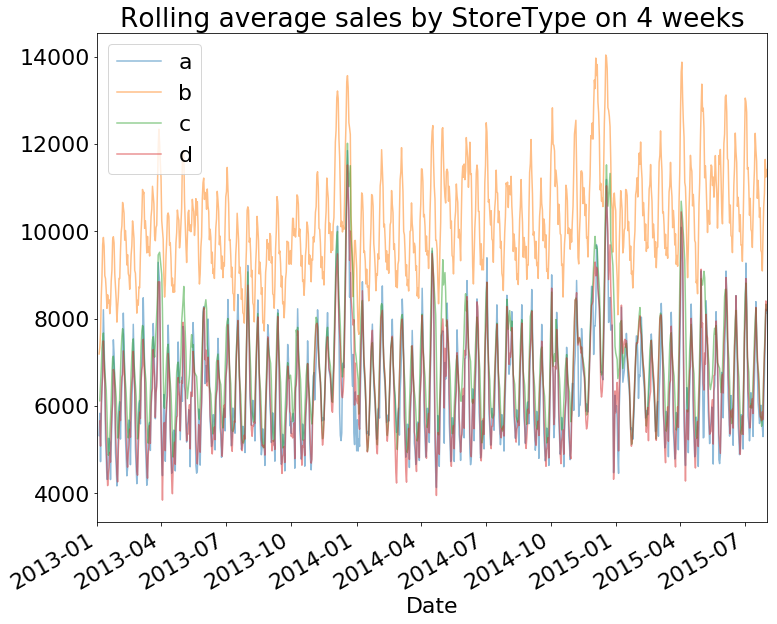

In [11]:
for key, value in gb:
    value.rolling(window=4).mean().plot(alpha=0.5)
plt.legend(['a', 'b', 'c', 'd'])
plt.title('Rolling average sales by StoreType on 4 weeks')

Text(0.5, 1.0, 'Rolling average sales by StoreType on 10 weeks')

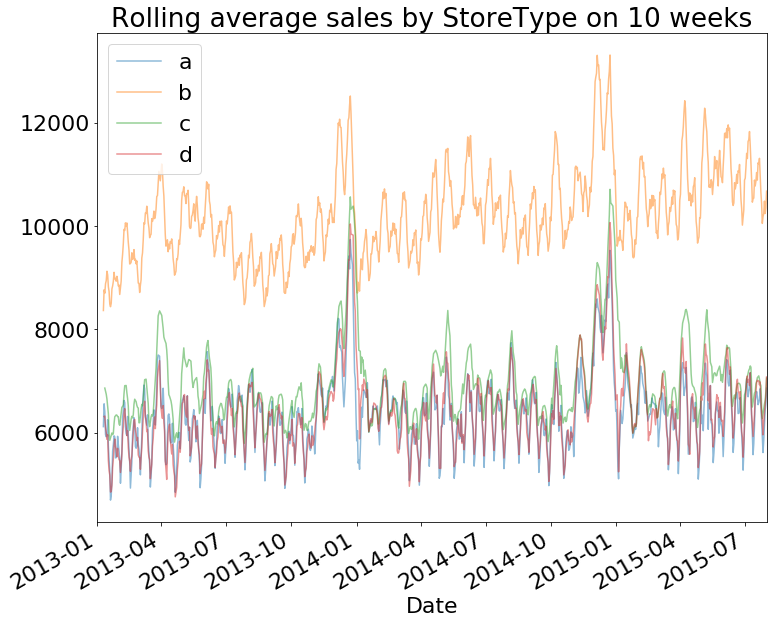

In [12]:
for key, value in gb:
    value.rolling(window=10).mean().plot(alpha=0.5)
plt.legend(['a', 'b', 'c', 'd'])
plt.title('Rolling average sales by StoreType on 10 weeks')

These graphs show that sales trend are very different from one type of store to another (especially b vs the others).
Moreover, there is a clear seasonality in sales.

Therefore, let us define an alert threshold that depends both on a fixed passed period and on the StoreType:

In [13]:
period_length = 3


gb = train.sort_index(ascending=True).groupby(['StoreType', 'Date']).mean()
gb['Previous_Average_Sales'] = gb['Sales'].groupby('StoreType').shift(1).rolling(period_length).mean()
gb['Previous_Std_Sales'] = gb['Sales'].groupby('StoreType').shift(1).rolling(period_length).std()

train_d = pd.merge(train, gb.reset_index()[['StoreType', 'Date', 'Previous_Average_Sales', 'Previous_Std_Sales']], on=['StoreType', 'Date'], how='left')

Here, I chose a period length to average over of 3 weeks in order to take into account sales seasonality, without being too restrictive.

The range is of the form `[ average - thresh_down * std, average + thresh_up * std ]`.

In [14]:
thresh_up = 5.0
thresh_down = 5.0

train_d['target'] = ((train_d.Sales > (train_d.Previous_Average_Sales + thresh_up * train_d.Previous_Std_Sales)) 
                     | 
                     (train_d.Sales < (train_d.Previous_Average_Sales - thresh_down * train_d.Previous_Std_Sales))).astype(int)

The thresholds can be modulated to adjust to user risk aversion.

In [15]:
train_d.target.value_counts() / train_d.shape[0]

0    0.759959
1    0.240041
Name: target, dtype: float64

# Train with H20 Random Forest

In [16]:
train = train_d.set_index('Date')

In [17]:
to_drop = ["Store", "Sales", "Customers", "Previous_Average_Sales", "Previous_Std_Sales"]  # Drop Customers to remove bias
features = train.drop(labels=to_drop, axis=1).columns.tolist()
y = train.Sales

In [18]:
h2o.init(nthreads=-1,max_mem_size='6G')

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_151"; OpenJDK Runtime Environment (build 1.8.0_151-8u151-b12-0ubuntu0.17.04.2-b12); OpenJDK 64-Bit Server VM (build 25.151-b12, mixed mode)
  Starting server from /home/pathoumieu/Documents/Deep_Learning_tuto/time_series/venv/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmptbxx5r70
  JVM stdout: /tmp/tmptbxx5r70/h2o_pathoumieu_started_from_python.out
  JVM stderr: /tmp/tmptbxx5r70/h2o_pathoumieu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Paris
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.3
H2O cluster version age:,3 days
H2O cluster name:,H2O_from_python_pathoumieu_hx5069
H2O cluster total nodes:,1
H2O cluster free memory:,5.333 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


## Split dataset into train, valid, test

In [19]:
print(train.index.min(), train.index.max())

2013-01-01 00:00:00 2015-07-31 00:00:00


In [20]:
valid_date = pd.to_datetime('2014-07-01', format='%Y-%m-%d')
test_date = pd.to_datetime('2015-01-01', format='%Y-%m-%d')

In [21]:
train_ = train[train.index < valid_date]
valid_ = train[(train.index >= valid_date) & (train.index < test_date)]
test_ = train[train.index >= test_date]

## Train

In [22]:
datasets = h2o.H2OFrame(train_), h2o.H2OFrame(valid_), h2o.H2OFrame(test_)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [23]:
# Make target categorical for binary classification

for dataset in datasets:
    dataset['target'] = dataset['target'].asfactor()

In [24]:
train_, valid_, test_ = datasets

In [25]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

rf = H2ORandomForestEstimator(
                model_id="v1",
                ntrees=100,
                max_depth=10,
                stopping_rounds=2,
                score_each_iteration=True,
                seed=42
)



rf.train(features, 'target', training_frame=train_, validation_frame=valid_)

drf Model Build progress: |███████████████████████████████████████████████| 100%


## Score

In [26]:
rf

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  v1


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.10453193832794963
RMSE: 0.3233139933995274
LogLoss: 0.3278260944019658
Mean Per-Class Error: 0.1655319123417156
AUC: 0.9083763360807234
pr_auc: 0.7319785756630001
Gini: 0.8167526721614469
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3639017247593216: 


,0,1,Error,Rate
0,326085.0,57311.0,0.1495,(57311.0/383396.0)
1,24527.0,95150.0,0.2049,(24527.0/119677.0)
Total,350612.0,152461.0,0.1627,(81838.0/503073.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3639017,0.6992776,204.0
max f2,0.1845236,0.8021606,276.0
max f0point5,0.4902070,0.6885131,146.0
max accuracy,0.4610766,0.8487655,159.0
max precision,0.9980692,1.0,0.0
max recall,0.0002613,1.0,399.0
max specificity,0.9980692,1.0,0.0
max absolute_mcc,0.3615193,0.5981320,205.0
max min_per_class_accuracy,0.3351391,0.8284131,217.0
max mean_per_class_accuracy,0.2559562,0.8344681,248.0


Gains/Lift Table: Avg response rate: 23,79 %, avg score: 23,75 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100005,0.7860645,3.8636152,3.8636152,0.9189833,0.8227548,0.9189833,0.8227548,0.0386381,0.0386381,286.3615242,286.3615242
,2,0.0200010,0.7577112,3.7175192,3.7905672,0.8842335,0.7704999,0.9016084,0.7966274,0.0371771,0.0758153,271.7519160,279.0567201
,3,0.0300015,0.7393153,3.5179937,3.6997094,0.8367752,0.7481760,0.8799974,0.7804769,0.0351818,0.1109970,251.7993654,269.9709352
,4,0.0400001,0.7243730,3.4727673,3.6429823,0.8260179,0.7317827,0.8665045,0.7683052,0.0347226,0.1457196,247.2767331,264.2982296
,5,0.0500006,0.7098651,3.4086303,3.5961100,0.8107625,0.7171503,0.8553557,0.7580738,0.0340881,0.1798076,240.8630301,259.6110036
,6,0.1000012,0.6365089,3.1957074,3.3959087,0.7601176,0.6741435,0.8077366,0.7161087,0.1597873,0.3395949,219.5707386,239.5908711
,7,0.1500018,0.5546002,2.7847854,3.1922009,0.6623774,0.5958378,0.7592835,0.6760184,0.1392409,0.4788358,178.4785401,219.2200941
,8,0.2000004,0.4813914,2.4322338,3.0022148,0.5785209,0.5163396,0.7140942,0.6360999,0.1216083,0.6004442,143.2233793,200.2214813
,9,0.2999996,0.3659728,1.8980264,2.6341544,0.4514566,0.4228699,0.6265489,0.5650237,0.1898011,0.7902453,89.8026397,163.4154444
,10,0.4000008,0.2235449,1.1826739,2.2712807,0.2813059,0.3003437,0.5402373,0.4988530,0.1182688,0.9085141,18.2673881,127.1280701




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.11997933973244385
RMSE: 0.34638033970253546
LogLoss: 0.37458147842970824
Mean Per-Class Error: 0.1993426033135246
AUC: 0.8745281686924833
pr_auc: 0.6653568583019104
Gini: 0.7490563373849666
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3085782569916234: 


,0,1,Error,Rate
0,82935.0,26886.0,0.2448,(26886.0/109821.0)
1,5487.0,29427.0,0.1572,(5487.0/34914.0)
Total,88422.0,56313.0,0.2237,(32373.0/144735.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3085783,0.6451380,217.0
max f2,0.2449175,0.7633369,245.0
max f0point5,0.5160505,0.6495757,115.0
max accuracy,0.4904351,0.8279822,125.0
max precision,0.9227841,1.0,0.0
max recall,0.0124166,1.0,392.0
max specificity,0.9227841,1.0,0.0
max absolute_mcc,0.3024347,0.5251362,220.0
max min_per_class_accuracy,0.3478341,0.7874778,198.0
max mean_per_class_accuracy,0.2836803,0.8006574,229.0


Gains/Lift Table: Avg response rate: 24,12 %, avg score: 25,77 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100321,0.7685205,3.3631995,3.3631995,0.8112948,0.7864333,0.8112948,0.7864333,0.0337400,0.0337400,236.3199517,236.3199517
,2,0.0201126,0.7476478,2.9833758,3.1728310,0.7196710,0.7580158,0.7653727,0.7721904,0.0300739,0.0638139,198.3375817,217.2830991
,3,0.0300411,0.7191748,3.4675414,3.2702318,0.8364649,0.7331223,0.7888684,0.7592785,0.0344275,0.0982414,246.7541420,227.0231839
,4,0.0400180,0.7015965,3.5052777,3.3288310,0.8455679,0.7097808,0.8030041,0.7469383,0.0349716,0.1332130,250.5277689,232.8830977
,5,0.0500086,0.6869028,3.3026165,3.3235939,0.7966805,0.6943448,0.8017408,0.7364312,0.0329954,0.1662084,230.2616482,232.3593873
,6,0.1000104,0.6300024,3.1058101,3.2147095,0.7492055,0.6594798,0.7754750,0.6979582,0.1552959,0.3215043,210.5810104,221.4709511
,7,0.1500605,0.5340486,2.5883446,3.0057963,0.6243788,0.5862659,0.7250794,0.6607051,0.1295469,0.4510512,158.8344649,200.5796253
,8,0.2000138,0.4667339,2.0647087,2.7707600,0.4980636,0.4969448,0.6683823,0.6198061,0.1031391,0.5541903,106.4708672,177.0760044
,9,0.3000035,0.3870094,1.6230129,2.3882217,0.3915146,0.4241784,0.5761037,0.5546044,0.1622845,0.7164748,62.3012909,138.8221721
,10,0.4,0.2955096,1.3903213,2.1387552,0.3353831,0.3452653,0.5159257,0.5022714,0.1390273,0.8555021,39.0321273,113.8755227



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2019-01-28 20:53:56,0.050 sec,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
,2019-01-28 20:53:57,1.382 sec,1.0,0.3380043,0.3725892,0.8845081,0.6686389,3.3897052,0.1825995,0.3815622,0.5983816,0.8064740,0.4926547,1.8867557,0.2970878
,2019-01-28 20:53:58,2.678 sec,2.0,0.3371620,0.3655391,0.8854548,0.6698463,3.4720875,0.1845512,0.3674766,0.4349492,0.8351100,0.5667180,2.4327886,0.2478046
,2019-01-28 20:53:59,3.216 sec,3.0,0.3350621,0.3586434,0.8885492,0.6803911,3.5530995,0.1802334,0.3576918,0.4080640,0.8523219,0.6201286,3.1048389,0.2302691
,2019-01-28 20:53:59,3.900 sec,4.0,0.3329830,0.3534630,0.8913046,0.6945130,3.7181088,0.1773637,0.3526420,0.3956696,0.8602729,0.6468845,3.4573914,0.2267800
,2019-01-28 20:54:00,4.557 sec,5.0,0.3301477,0.3455325,0.8954731,0.7016673,3.7093722,0.1744486,0.3514843,0.3845996,0.8625220,0.6506236,3.5524585,0.2231388
,2019-01-28 20:54:01,5.342 sec,6.0,0.3298593,0.3439614,0.8960444,0.7041419,3.7333942,0.1753180,0.3491783,0.3794745,0.8671129,0.6574435,3.4593247,0.2243479
,2019-01-28 20:54:02,6.147 sec,7.0,0.3276354,0.3382817,0.8994063,0.7130774,3.7589176,0.1717963,0.3486294,0.3777440,0.8684189,0.6605654,3.5052994,0.2218883
,2019-01-28 20:54:02,6.793 sec,8.0,0.3262109,0.3343335,0.9017424,0.7184695,3.7901498,0.1701863,0.3477114,0.3755969,0.8708038,0.6634065,3.3537240,0.2211283
,2019-01-28 20:54:03,7.494 sec,9.0,0.3241577,0.3294825,0.9047207,0.7253502,3.8152721,0.1687314,0.3466517,0.3735003,0.8722431,0.6656997,3.3664187,0.2155318


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
DayOfWeek,192041.9062500,1.0,0.5631972
Day,51149.4687500,0.2663454,0.1500050
Promo,26972.1386719,0.1404492,0.0791006
WeekOfYear,20284.5136719,0.1056255,0.0594880
StoreType,19641.5664062,0.1022775,0.0576024
Month,13327.1806641,0.0693973,0.0390843
SchoolHoliday,5636.0708008,0.0293481,0.0165288
Year,3422.4306641,0.0178213,0.0100369
CompetitionDistance,2742.1125488,0.0142787,0.0080417
Assortment,1873.9334717,0.0097579,0.0054956


In [27]:
rf.score_history()

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2019-01-28 20:53:56,0.050 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-01-28 20:53:57,1.382 sec,1.0,0.338004,0.372589,0.884508,0.668639,3.389705,0.182599,0.381562,0.598382,0.806474,0.492655,1.886756,0.297088
2,,2019-01-28 20:53:58,2.678 sec,2.0,0.337162,0.365539,0.885455,0.669846,3.472087,0.184551,0.367477,0.434949,0.835110,0.566718,2.432789,0.247805
3,,2019-01-28 20:53:59,3.216 sec,3.0,0.335062,0.358643,0.888549,0.680391,3.553100,0.180233,0.357692,0.408064,0.852322,0.620129,3.104839,0.230269
4,,2019-01-28 20:53:59,3.900 sec,4.0,0.332983,0.353463,0.891305,0.694513,3.718109,0.177364,0.352642,0.395670,0.860273,0.646885,3.457391,0.226780
5,,2019-01-28 20:54:00,4.557 sec,5.0,0.330148,0.345533,0.895473,0.701667,3.709372,0.174449,0.351484,0.384600,0.862522,0.650624,3.552458,0.223139
6,,2019-01-28 20:54:01,5.342 sec,6.0,0.329859,0.343961,0.896044,0.704142,3.733394,0.175318,0.349178,0.379475,0.867113,0.657443,3.459325,0.224348
7,,2019-01-28 20:54:02,6.147 sec,7.0,0.327635,0.338282,0.899406,0.713077,3.758918,0.171796,0.348629,0.377744,0.868419,0.660565,3.505299,0.221888
8,,2019-01-28 20:54:02,6.793 sec,8.0,0.326211,0.334333,0.901742,0.718470,3.790150,0.170186,0.347711,0.375597,0.870804,0.663406,3.353724,0.221128
9,,2019-01-28 20:54:03,7.494 sec,9.0,0.324158,0.329482,0.904721,0.725350,3.815272,0.168731,0.346652,0.373500,0.872243,0.665700,3.366419,0.215532


In [28]:
rf.model_performance(test_data=test_).auc()

0.8697759346330345

==> Final AUC on test set: 0.87

# Suggested improvements

* Compute features averaged over different time windows
* Use Time Series neural networks like LSTM of TCN
* Make target dependent of store id
* Cross validate model
* Smart fillna for missing targets (very few)